# Intra - Inter connectivity

Create the first figure, that tries to replicate the correlation between intra and inter connectivity
described in existing papers

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from statannotations.Annotator import Annotator
import itertools 

# ignore warnings for easier plotting
import warnings
warnings.filterwarnings("ignore")

from load_data import load_data

In [72]:
sns.set(style='darkgrid', context='paper', palette='Set1', font="serif")

In [73]:
# Hue colors order and names
# auxiliar dict to put correct order in the figure
map_hue_color = {
    "EDSS_group": ["EDSS<3", "EDSS>=3"],
    "SDMT_group": ["SDMT>=40", "SDMT<40"],
    "G_norm": ['G_z<=0', 'G_z>0'], 
    "Corr_norm": ['C_z<=0', 'C_z>0'],
    "disease": ["HC", "MS"],
    "GROUP": ["HC", "CIS", "RRMS", "SPMS", "PPMS"],
    "CENTER": ["CLINIC", "MAINZ", "MILAN", "NAPLES", "OSLO", "LONDON", "AMSTERDAM"],
    "groups" : ["HC", "EDSS<3", "EDSS>=3", "SDMT>=40", "SDMT<40"]
    # "GROUP": ["HC", "RRMS", "SPMS", "PPMS"]
}

# get the progressives together.
mapping_prog = {
    "HC": "HC",
    "CIS": "CIS", 
    "RRMS": "RRMS", 
    "SPMS": "PMS", 
    "PPMS": "PMS"
}

df_merged = load_data()

In [74]:
print(len(df_merged))
x1 = "Comm_ratio"
x2 = "CC_ratio_area"

y1 = "SC_spl_full"
y2 = "SC_eff_full"


tidy = (
    df_merged[["Comm_ratio", "CC_ratio_area", "SC_spl_full", "SC_eff_full"]].stack() # pull the columns into row variables   
      .to_frame() # convert the resulting Series to a DataFrame
      .reset_index() # pull the resulting MultiIndex into the columns
      .rename(columns={0: 'val'}) # rename the unnamed column
)

print(tidy.head())


697
   level_0        level_1         val
0        0     Comm_ratio    0.010277
1        0  CC_ratio_area    0.221946
2        0    SC_spl_full    0.014275
3        0    SC_eff_full  108.307811
4        1     Comm_ratio    0.010640


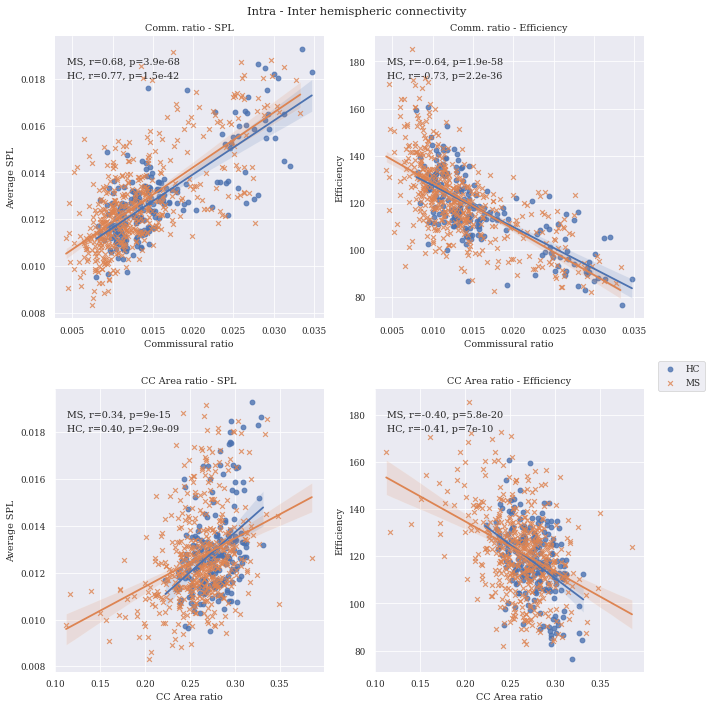

In [75]:
def annotate(col1, col2, data, multihue=False, **kwargs):
    if len(data[col1]) >= 2 or len(data[col2]) >= 2:
        r, p = stats.pearsonr(data[col1], data[col2])
        ax = plt.gca()

        # hardcoded, udpate if working with other labels
        x_pos = 0.05
        if multihue:
            label = kwargs["label"]
            dict_of_labels = {"CIS": 0, "RRMS": 1, "PMS": 2, 'MS':0, 'HC':1}
            y_pos = 0.9 - dict_of_labels[kwargs["label"]]*0.05
        else:
            label =  " "
            y_pos = 0.9
        
        ax.text(x_pos, y_pos, f'{label}, ' + 'r={:.2f}, p={:.2g}'.format(r, p),
                transform=ax.transAxes)

to_correct = 'C(CENTER)'

results = smf.ols(f'{x1} ~ {to_correct}', data=df_merged).fit()
# df_merged[f"{x1}"] = results.resid + results.params.Intercept
results = smf.ols(f'{y1} ~ {to_correct}', data=df_merged).fit()
# df_merged[f"{y1}"] = results.resid + results.params.Intercept
results = smf.ols(f'{y2} ~ {to_correct}', data=df_merged).fit()
# df_merged[f"{y2}"] = results.resid + results.params.Intercept
results = smf.ols(f'{y2} ~ {to_correct}', data=df_merged).fit()
# df_merged[f"{y2}"] = results.resid + results.params.Intercept


x1 = "Comm_ratio"
x2 = "CC_ratio_area"

y1 = "SC_spl_full"
y2 = "SC_eff_full"

# build 4 dataframes manually, with columns intra/inter which means the variable intra/inter for that 
df_x1_y1 = pd.DataFrame({"inter": df_merged[x1].values, "intra": df_merged[y1].values, "disease": df_merged["disease"].values, "EDSS": df_merged["EDSS"].values})
df_x1_y1["inter_name"] = x1
df_x1_y1["intra_name"] = y1

df_x1_y2 = pd.DataFrame({"inter": df_merged[x1].values, "intra": df_merged[y2].values, "disease": df_merged["disease"].values, "EDSS": df_merged["EDSS"].values})
df_x1_y2["inter_name"] = x1
df_x1_y2["intra_name"] = y2

df_x2_y1 = pd.DataFrame({"inter": df_merged[x2].values, "intra": df_merged[y1].values, "disease": df_merged["disease"].values, "EDSS": df_merged["EDSS"].values})
df_x2_y1["inter_name"] = x2
df_x2_y1["intra_name"] = y1

df_x2_y2 = pd.DataFrame({"inter": df_merged[x2].values, "intra": df_merged[y2].values, "disease": df_merged["disease"].values, "EDSS": df_merged["EDSS"].values})
df_x2_y2["inter_name"] = x2
df_x2_y2["intra_name"] = y2

# concatenate the four dataframes
df_intra_inter = pd.concat([df_x1_y1, df_x1_y2, df_x2_y1, df_x2_y2])

# for color as disease
g = sns.lmplot(data=df_intra_inter, x="inter", y="intra", hue="disease", hue_order=["HC", "MS"], row="inter_name", col="intra_name", facet_kws={"sharex":False, "sharey":False}, scatter_kws={"alpha":0.8}, legend=False, legend_out=True, markers=["o", "x"], palette="deep")
g.map_dataframe(annotate, "inter", "intra", multihue=True)

# For color as EDSS
"""
# First, assign HC as EDSS==0.
df_merged.EDSS[df_merged.EDSS.isna()] = 0
EDSS_norm =(df_merged.EDSS-df_merged.EDSS.min())/(df_merged.EDSS.max()-df_merged.EDSS.min())

# for color as EDSS
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("viridis"), N=10)
df_merged["EDSS_c"] = [cmap(x) for x in EDSS_norm]
color_array = df_merged["EDSS_c"].values
color_array = np.array([*color_array])
print(color_array.shape)
g = sns.lmplot(data=df_intra_inter, x="inter", y="intra", hue="disease", hue_order=["HC", "MS"], markers=["o", "x"], row="inter_name", col="intra_name", facet_kws={"sharex":False, "sharey":False}, scatter_kws={"color": color_array, "alpha": 0.8}, line_kws={'color': 'darkblue', "alpha": 0.8}, legend=False, legend_out=True)
"""
## Create the correct titles

fig = g.fig
fig.suptitle("Intra - Inter hemispheric connectivity")
a1 = fig.axes[0]
a1.set_title("Comm. ratio - SPL")
a1.set_xlabel("Commissural ratio")
a1.set_ylabel("Average SPL")

a2 = fig.axes[1]
a2.set_title("Comm. ratio - Efficiency")
a2.set_xlabel("Commissural ratio")
a2.set_ylabel("Efficiency")

a3 = fig.axes[2]
a3.set_title("CC Area ratio - SPL")
a3.set_xlabel("CC Area ratio")
a3.set_ylabel("Average SPL")

a4 = fig.axes[3]
a4.set_title("CC Area ratio - Efficiency")
a4.set_xlabel("CC Area ratio")
a4.set_ylabel("Efficiency")

plt.legend(bbox_to_anchor=(1.05, 1.1), loc='upper left', borderaxespad=0)
plt.tight_layout()

## TODO: POSAR LLEGENDA MANUALMENT
## TODOTODO: WE SHOULD ADD BACK THE HC PATIENTS, AND PUT THEM USING CROSS, AND ALSO ADD THE 


plt.savefig("/home/extop/GERARD/PAPERS/PAPER_COBRA/FIGURES/FIg1_intrainter.png", dpi=300)

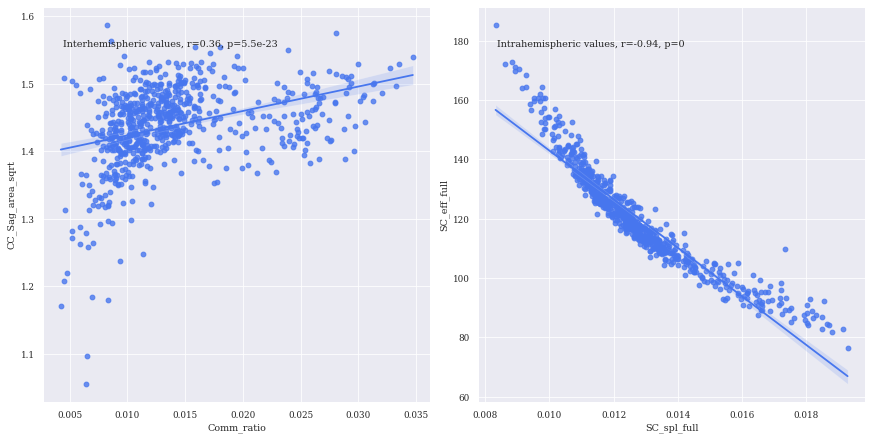

In [78]:
def annotate_axis(col1, col2, data, ax, label, level=0):
    """
    Version of the annotator function but
    for 

    """
    r, p = stats.pearsonr(data[col1], data[col2])

    # hardcoded, udpate if working with other labels
    x_pos = 0.05 
    y_pos = 0.9 - level*0.05

    ax.text(x_pos, y_pos, f'{label}, ' + 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

# Inter vs Inter

# fer un subplot 2x1.
# i fer que cada un siguin les figures.
sns.set(style='darkgrid', context='paper', palette='turbo', font="serif")
f, axes = plt.subplots(1, 3, figsize=(12,4), constrained_layout=True)
axes = axes.ravel()


x1 = "Comm_ratio"
x2 = "CC_Sag_area_sqrt"

y1 = "Comm_ratio"
y2 = "CC_ratio_area"

z1 = "Comm_ratio"
z2 = "Full_CC"

sns.regplot(x=x1, y=x2, data=df_merged, marker='o', ax=axes[0])
annotate_axis(x1, x2, df_merged, axes[0], "Interhemispheric values", 0)

sns.regplot(x=y1, y=y2, data=df_merged, marker='o', ax=axes[1])
annotate_axis(y1, y2, df_merged, axes[1], "Intrahemispheric values", 0)

sns.regplot(x=z1, y=z2, data=df_merged, marker='o', ax=axes[2])
annotate_axis(z1, z2, df_merged, axes[2], "Intrahemispheric values", 0)



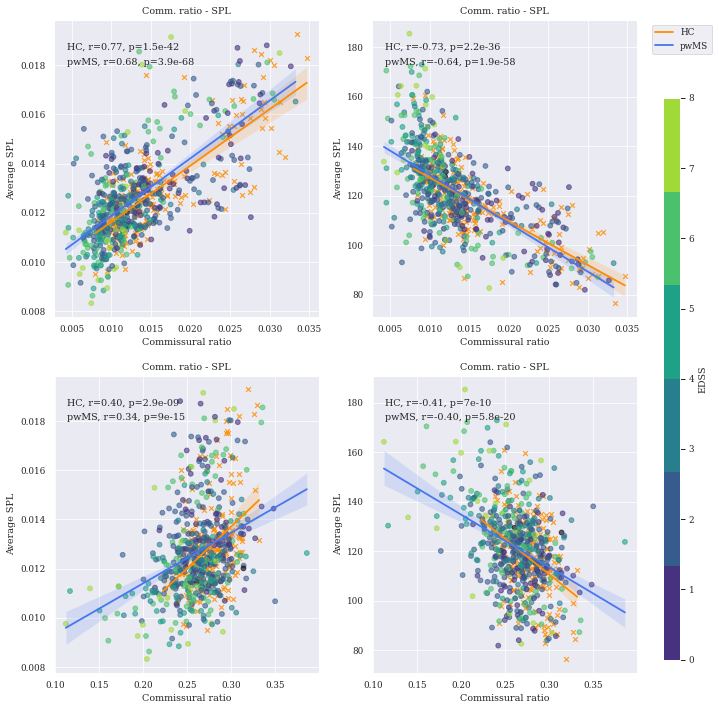

In [ ]:
def annotate_axis(col1, col2, data, ax, label, level=0):
    """
    Version of the annotator function but
    for 

    """
    r, p = stats.pearsonr(data[col1], data[col2])

    # hardcoded, udpate if working with other labels
    x_pos = 0.05 
    y_pos = 0.9 - level*0.05

    ax.text(x_pos, y_pos, f'{label}, ' + 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("viridis"))

def create_subplot(x, y, ax, df, title, xlabel, ylabel, legend=True):
    ## Comm ratio - SPL
    # HC
    df_merged_hc = df_merged[df.disease=="HC"]
    sns.regplot(x=x, y=y, data=df_merged_hc, scatter_kws={"alpha": 0.8}, marker='x', color='darkorange', ax=ax)

    # pwMS
    df_merged_pwms = df_merged[df.disease!="HC"]

    EDSS_norm =(df_merged_pwms.EDSS-df_merged_pwms.EDSS.min())/(df_merged_pwms.EDSS.max()-df_merged_pwms.EDSS.min())
    df_merged_pwms_EDSS = [cmap(x) for x in EDSS_norm]
    color_array = np.array([*df_merged_pwms_EDSS])

    sns.regplot(x=x, y=y, data=df_merged_pwms, scatter_kws={"color": color_array, "alpha": 0.6}, marker='o', ax=ax)

    # annotate
    annotate_axis(x, y, df_merged_hc, ax, "HC", 0)
    annotate_axis(x, y, df_merged_pwms, ax, "pwMS", 1)

    # Title and axis
    ax.set_title("Comm. ratio - SPL")
    ax.set_xlabel("Commissural ratio")
    ax.set_ylabel("Average SPL")
    if legend: ax.legend(labels=['HC', 'pwMS'], bbox_to_anchor=(1.04, 1), loc="upper left")

## Second version
# Don't use lmplot, its shite
# use subplot, and for each axis plot the things separately
sns.set(style='darkgrid', context='paper', palette='turbo', font="serif")
f, axes = plt.subplots(2, 2, figsize=(12,12), constrained_layout=True)
axes = axes.ravel()

## Comm ratio - Average SPL
create_subplot(x1, y1, axes[0], df_merged, "Comm. ratio - SPL", "Commissural ratio", "Average SPL", False)

## Comm ratio - Efficiency
create_subplot(x1, y2, axes[1], df_merged, "Comm. ratio - Efficiency", "Commissural ratio", "Efficiency")

## Comm ratio - Average SPL
create_subplot(x2, y1, axes[2], df_merged, "CC Area ratio - SPL", "CC Area ratio", "Average SPL", False)

## Comm ratio - Efficiency
create_subplot(x2, y2, axes[3], df_merged, "CC Area ratio - Efficiency", "CC Area ratio", "Efficiency", False)

## LEGENDS
# Need to one one for colors and one for markers
# the one for colors needs to be a colorbar
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.83, 0.14, 0.02, 0.65])

# and the other one just a classic legend
import matplotlib as mpl
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=df_merged.EDSS.min(), vmax=df_merged.EDSS.max()), cmap=cmap),
             cax=cbar_ax, orientation='vertical', label='EDSS')

plt.savefig("/home/extop/GERARD/PAPERS/PAPER_COBRA/FIGURES/Figure_Intraiter.pdf", dpi=300)


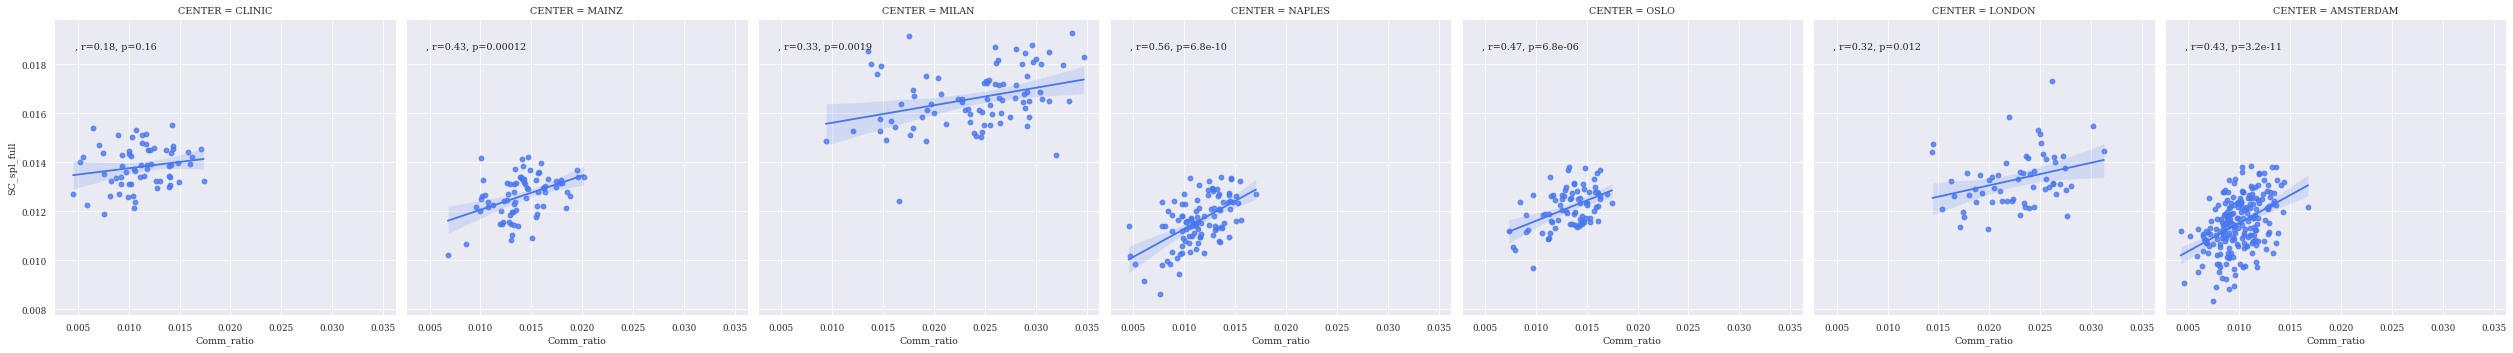

In [ ]:
variable_to_plot = "Comm_ratio"
cc = "SC_spl_full"

results = smf.ols(f'{variable_to_plot} ~ C(CENTER)', data=df_merged).fit()
df_merged[f"{variable_to_plot}_C"] = results.resid

results = smf.ols(f'{cc} ~ C(CENTER)', data=df_merged).fit()
df_merged[f"{cc}_C"] = results.resid

df_merged['disease'] = np.where((df_merged['GROUP']== 'HC'), "HC", "MS")
df_merged_hc = df_merged[df_merged.disease == "HC"]
g = sns.lmplot(data=df_merged, x=f"{variable_to_plot}", y=f"{cc}", col="CENTER")
g.map_dataframe(annotate, f"{variable_to_plot}", f"{cc}", multihue=False)

In [ ]:
## Linear analysis
def basic_analysis(df, title, to_plot):
    """
    Perform a basic analysis of the data
    Distribution of G/cs and BestCorr.
    """
    for x in to_plot:

        moore_lm = smf.ols(f'{x} ~ AGE + SEX + C(CENTER)', data=df).fit()
        print(moore_lm.summary())
        table = sm.stats.anova_lm(moore_lm, typ=2)
        print(table)

basic_analysis(df_merged, "Distribution", ['EDSS','SDMT'])

                            OLS Regression Results                            
Dep. Variable:                   EDSS   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     42.99
Date:                Fri, 30 Sep 2022   Prob (F-statistic):           1.02e-51
Time:                        12:48:05   Log-Likelihood:                -898.22
No. Observations:                 486   AIC:                             1814.
Df Residuals:                     477   BIC:                             1852.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0580    